# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [6]:
!unzip '/content/spectral_clustering.zip'
%cd spectral_clustering
!pip install -r requirements.txt
!pip install networkx

Archive:  /content/spectral_clustering.zip
   creating: spectral_clustering/
   creating: spectral_clustering/.ipynb_checkpoints/
  inflating: spectral_clustering/.ipynb_checkpoints/spectral_clustering-checkpoint.ipynb  
  inflating: spectral_clustering/.ipynb_checkpoints/spectral_clustering_2122-checkpoint.ipynb  
  inflating: spectral_clustering/README.md  
  inflating: spectral_clustering/build_similarity_graph.py  
   creating: spectral_clustering/data/
  inflating: spectral_clustering/data/four_elements.bmp  
  inflating: spectral_clustering/data/fruit_salad.bmp  
  inflating: spectral_clustering/generate_data.py  
  inflating: spectral_clustering/image_segmentation.py  
  inflating: spectral_clustering/requirements.txt  
  inflating: spectral_clustering/spectral_clustering.ipynb  
  inflating: spectral_clustering/spectral_clustering.py  
  inflating: spectral_clustering/utils.py  
/content/spectral_clustering/spectral_clustering
Looking in indexes: https://pypi.org/simple, https:

In [7]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
import scipy
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

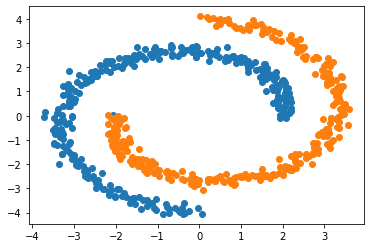

In [8]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [9]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """

    # Build similarity graph
    similarities = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i<j: # we discard case i = j in order to not consider self loops
                # also, similarity matrix is symmetric 
                similarities[i,j] = np.exp(-np.linalg.norm(X[i,:]-X[j,:])**2/(2*var))
                similarities[j,i] = similarities[i,j]


    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        # Build epsilon graph
        W[np.where(similarities>=eps)] = similarities[np.where(similarities>=eps)]
        pass

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        # Build kNN graph
        idx = np.argsort(similarities)[:, n-k:]
        for i in range(n):
            for j in idx[i]:
                W[i,j] = similarities[i,j]
                W[j,i] = similarities[i,j]
        pass 

    return W


AttributeError: ignored

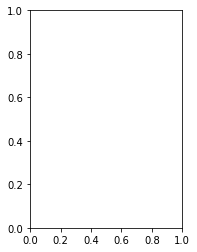

In [10]:
# Example

W = build_similarity_graph(X, eps=0.6)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [ ]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    D = np.diag(np.sum(W, axis=1))
    L_unn = D - W
    if laplacian_normalization=='unn':
        L = L_unn
    elif laplacian_normalization=='sym':
        L = np.dot(fractional_matrix_power(D,-1/2),np.dot(L_unn,fractional_matrix_power(D,1/2)))
    elif laplacian_normalization=='rw':
        L = np.dot(np.linalg.inv(D), L_unn)
    
    # for example (unnormalized): L = D - W
    return L

## Clustering

In [ ]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E = None
    U = None
    vals, vecs = scipy.linalg.eig(L)
    E = np.diag(vals[np.argsort(vals)]).real
    U = vecs[:, np.argsort(vals)].real

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """

    # Strategy used to choose automatically the eigenvectors
    if chosen_eig_indices == None:
        idx = np.argsort(vals)
        eigenvalues = vals[idx].real
        # Normalize eigenvalues by their sum
        eigenvalues = eigenvalues/np.sum(eigenvalues)
        # Initialize list of chosen eig indices
        chosen_eig_indices = []
        # Initialize sum of chosen eigenvalues
        sum = eigenvalues[1]
        # Check excceeding threshold
        i = 1
        while sum < 1e-5:
            chosen_eig_indices.append(i)
            i += 1
            sum += eigenvalues[i]
    kmeans = KMeans(n_clusters=num_classes)
    kmeans.fit(U[:,chosen_eig_indices])
    Y = kmeans.labels_
    return Y

C:\Users\dsiko\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\dsiko\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\dsiko\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\dsiko\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

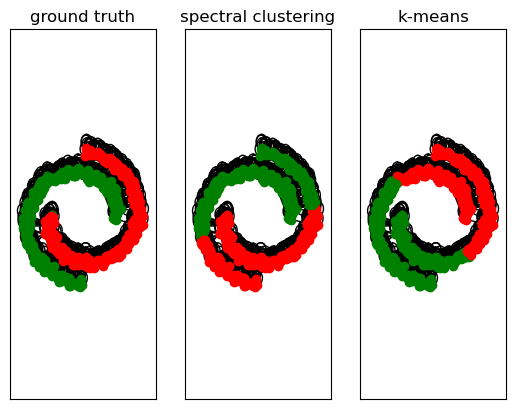

In [ ]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [ ]:
def parameter_sensitivity():
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = [1, 2]

    """
    Choose candidate parameters
    """
    if parameter == 'eps' :
        parameter_type = 'eps' 
        parameter_candidate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]   # the epsilon threshold

    elif parameter == 'k' :
        parameter_type = 'k' 
        parameter_candidate = [i for i in range(1,100,5)]  # the number of neighbours for the kNN graph
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [ ]:
def image_segmentation(input_img='four_elements.bmp',  eps=0.0, k=2, num_classes=5, chosen_eig_indices=None):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0
    k = 2
    laplacian_normalization = 'unn'
    chosen_eig_indices = [1]
    num_classes = 1

    W = build_similarity_graph(Xr, var=var, eps=eps, k=k) 
    L = build_laplacian(W, laplacian_normalization) 
    Y_rec = spectral_clustering(L, chosen_eig_indices=chosen_eig_indices, num_classes=num_classes) 

    # Visualization
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

C:\Users\dsiko\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


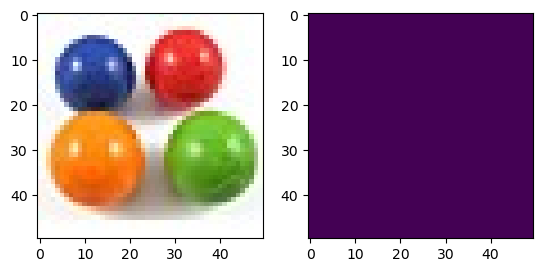

In [ ]:
image_segmentation(input_img='four_elements.bmp', num_classes=5, k=15, chosen_eig_indices=None)

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

In [ ]:
min_span_tree?

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

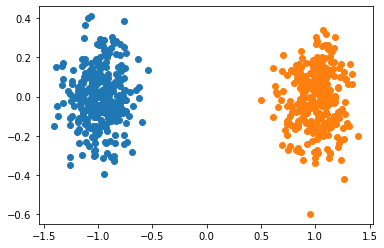

In [ ]:
blobs?
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

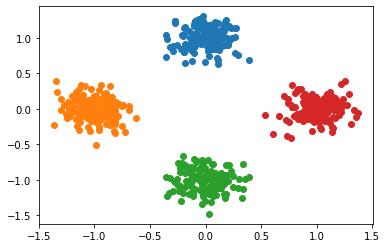

In [ ]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

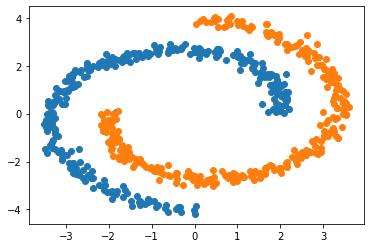

In [ ]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

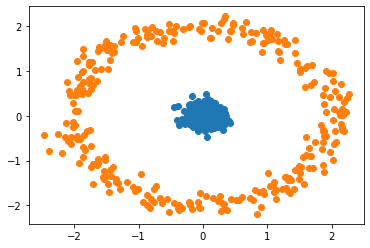

In [ ]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 